In [ ]:
import os
import numpy as np
from PIL import Image, ImageFilter
import cv2
import torch,torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/BinarySplit1"

In [ ]:
def load_data(path, test_split, val_split, batch_size, input_size):

    transform_dict = {'src':transforms.Compose([transforms.RandomHorizontalFlip(),
                                                transforms.Resize((224,224)),
                                                transforms.RandomVerticalFlip(),
                                                transforms.RandomRotation(15),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])}

    org_data = datasets.ImageFolder(root=path,transform =transform_dict['src'])
    testSubsetSize = int(len(org_data) * test_split)
    valDataSize = int(len(org_data) * val_split)
    trainSubsetSize = len(org_data) - valDataSize - testSubsetSize
    train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(org_data,[trainSubsetSize, testSubsetSize, valDataSize])
    trainSetDataLoader = DataLoader(train_dataset, batch_size, shuffle=True)
    testSetDataLoader = DataLoader(test_dataset, batch_size, shuffle=False)
    valSetDataLoader = DataLoader(val_dataset, batch_size, shuffle=False)

    return trainSetDataLoader, testSetDataLoader, valSetDataLoader

In [ ]:
train_loader,test_loader,val_loader=load_data(path,test_split=0.1,val_split= 0.1,batch_size=32, input_size=[200,200])

In [ ]:

model = torchvision.models.shufflenet_v2_x1_0(pretrained=False, num_classes=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

criterion = torch.nn.CrossEntropyLoss()

import matplotlib.pyplot as plt

train_acc_shuffleNet = []
val_acc_shuffleNet = []
LR_shuffleNet = [0.001, 0.01, 0.1]

for lr in LR_shuffleNet:

    optimizer_shuffleNet = optim.Adam(model.parameters(), lr=lr)

    train_acc_lr = []
    val_acc_lr = []

    for epoch in range(50):
        train_loss = 0.0
        correct_train = 0
        total_train = 0


        model.train()

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer_shuffleNet.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            optimizer_shuffleNet.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()


        train_acc_lr.append(correct_train / total_train)


        model.eval()

        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()


        val_acc_lr.append(correct_val / total_val)

        print('Epoch %d, Training loss: %.3f, Training accuracy: %.3f, Validation accuracy: %.3f' %
              (epoch + 1, train_loss / len(train_loader), train_acc_lr[-1], val_acc_lr[-1]))


    train_acc_shuffleNet.append(train_acc_lr[-1])
    val_acc_shuffleNet.append(val_acc_lr[-1])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1, Training loss: 0.695, Training accuracy: 0.572, Validation accuracy: 0.613
Epoch 2, Training loss: 0.647, Training accuracy: 0.616, Validation accuracy: 0.662
Epoch 3, Training loss: 0.619, Training accuracy: 0.666, Validation accuracy: 0.680
Epoch 4, Training loss: 0.603, Training accuracy: 0.676, Validation accuracy: 0.693
Epoch 5, Training loss: 0.580, Training accuracy: 0.701, Validation accuracy: 0.696
Epoch 6, Training loss: 0.564, Training accuracy: 0.712, Validation accuracy: 0.707
Epoch 7, Training loss: 0.550, Training accuracy: 0.722, Validation accuracy: 0.691
Epoch 8, Training loss: 0.546, Training accuracy: 0.722, Validation accuracy: 0.751
Epoch 9, Training loss: 0.534, Training accuracy: 0.731, Validation accuracy: 0.709
Epoch 10, Training loss: 0.525, Training accuracy: 0.735, Validation accuracy: 0.707
Epoch 11, Training loss: 0.506, Training accuracy: 0.751, Validation accuracy: 0.753
Epoch 12, Training loss: 0.515, Training accuracy: 0.747, Validation accur

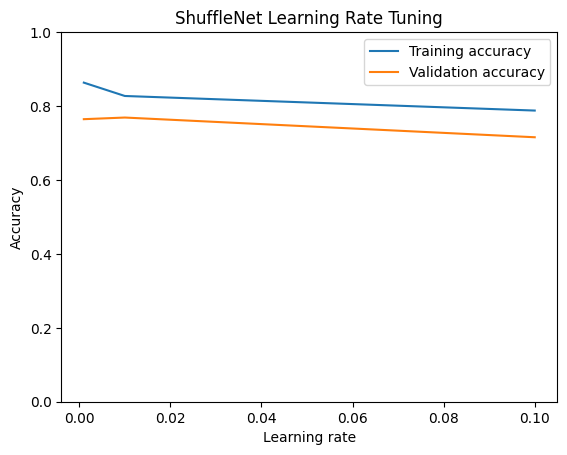

In [ ]:

plt.plot(LR_shuffleNet, train_acc_shuffleNet, label='Training accuracy')
plt.plot(LR_shuffleNet, val_acc_shuffleNet, label='Validation accuracy')
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('ShuffleNet Learning Rate Tuning')
plt.legend()
plt.show()


In [ ]:
train_acc_shuffleNet

[0.8633333333333333, 0.8272222222222222, 0.7877777777777778]

In [ ]:
val_acc_shuffleNet

[0.7644444444444445, 0.7688888888888888, 0.7155555555555555]